In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import community, cuts
import pandas as pd
from typing import List, Dict, Any
from collections import defaultdict

In [ ]:
class CommunityDetectionPipeline:
    """A pipeline for detecting and analyzing communities in social network graphs."""

    def __init__(self, graph: nx.Graph):
        """
        Initialize the pipeline with a networkx graph.

        Args:
            graph: A networkx Graph object representing the social network
        """
        self.graph = graph
        self.community_partitions = {}
        self.metrics = defaultdict(dict)

    def detect_communities(self, methods: List[str] = None) -> Dict[str, List]:
        """
        Detect communities using specified methods.

        Args:
            methods: List of methods to use. Defaults to ['louvain', 'label_propagation', 'girvan_newman']

        Returns:
            Dictionary mapping method names to their community partitions
        """
        if methods is None:
            methods = ['louvain', 'label_propagation', 'girvan_newman']

        for method in methods:
            if method == 'louvain':
                self.community_partitions[method] = list(community.louvain_communities(self.graph))
            elif method == 'label_propagation':
                self.community_partitions[method] = list(community.label_propagation_communities(self.graph))
            elif method == 'girvan_newman':
                generator = community.girvan_newman(self.graph)
                self.community_partitions[method] = max(generator,
                    key=lambda partition: community.modularity(self.graph, partition))

        return self.community_partitions

    def calculate_metrics(self) -> Dict[str, Dict[str, float]]:
        """
        Calculate evaluation metrics for each community detection method.

        Returns:
            Dictionary of metrics for each method
        """
        for method, partition in self.community_partitions.items():
            self.metrics[method] = {
                'num_communities': len(partition),
                'modularity': community.modularity(self.graph, partition),
                'conductance': np.mean([cuts.conductance(self.graph, c) for c in partition]),
                'normalized_cut': np.mean([cuts.normalized_cut_size(self.graph, c) for c in partition])
            }
        return dict(self.metrics)

    def create_metrics_dataframe(self) -> pd.DataFrame:
        """
        Create a DataFrame comparing metrics across methods.

        Returns:
            pandas DataFrame with metrics comparison
        """
        metrics_data = []
        for method, metrics in self.metrics.items():
            metrics_data.append({
                'Algorithm': method.replace('_', ' ').title(),
                'Num Communities': metrics['num_communities'],
                'Modularity': metrics['modularity'],
                'Conductance': metrics['conductance'],
                'Normalized Cut': metrics['normalized_cut']
            })
        return pd.DataFrame(metrics_data)

    def _create_community_node_colors(self, communities: List[set]) -> List[tuple]:
        """
        Create color mapping for nodes based on their community membership.

        Args:
            communities: List of sets containing node communities

        Returns:
            List of RGB color tuples for each node
        """
        node_colors = []
        for node in self.graph:
            for idx, comm in enumerate(communities):
                if node in comm:
                    node_colors.append(plt.cm.jet(idx / len(communities)))
                    break
        return node_colors

    def visualize_communities(self, figsize: tuple = (20, 6)) -> None:
        """
        Visualize detected communities for all methods.

        Args:
            figsize: Figure size as (width, height)
        """
        num_methods = len(self.community_partitions)
        fig, axes = plt.subplots(1, num_methods, figsize=figsize)

        if num_methods == 1:
            axes = [axes]

        for ax, (method, partition) in zip(axes, self.community_partitions.items()):
            node_colors = self._create_community_node_colors(partition)
            pos = nx.spring_layout(self.graph, k=0.3, iterations=50, seed=2)
            modularity = self.metrics[method]['modularity']

            title = f"{method.replace('_', ' ').title()}\n"
            title += f"{len(partition)} communities (Modularity: {modularity:.3f})"
            ax.set_title(title)

            nx.draw(self.graph, pos=pos, node_size=500, node_color=node_colors,
                   with_labels=True, font_size=10, ax=ax)

        plt.tight_layout()
        plt.show()

    def plot_metrics_comparison(self, figsize: tuple = (18, 7)) -> None:
        """
        Plot comparison of metrics across methods.

        Args:
            figsize: Figure size as (width, height)
        """
        metrics_df = self.create_metrics_dataframe()

        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # Number of communities comparison
        axes[0].bar(metrics_df['Algorithm'], metrics_df['Num Communities'], color="#8E44AD")
        axes[0].set_title("Num Communities Comparison")
        axes[0].set_xlabel("Algorithm")
        axes[0].set_ylabel("Num Communities")

        # Other metrics comparison
        bar_width = 0.6
        x = np.arange(len(metrics_df['Algorithm']))

        axes[1].bar(x - bar_width/2, metrics_df['Modularity'],
                   width=bar_width, label='Modularity', color="#F2D140")
        axes[1].bar(x - bar_width/2, metrics_df['Conductance'],
                   width=bar_width, label='Conductance', color="#FF6347",
                   bottom=metrics_df['Modularity'])
        axes[1].bar(x - bar_width/2, metrics_df['Normalized Cut'],
                   width=bar_width, label='Normalized Cut', color="#48C9B0",
                   bottom=metrics_df['Modularity'] + metrics_df['Conductance'])

        axes[1].set_title("Comparison of Metrics")
        axes[1].set_xlabel("Algorithm")
        axes[1].set_ylabel("Value")
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(metrics_df['Algorithm'])
        axes[1].legend()

        plt.tight_layout()
        plt.show()

Community Detection Pipeline Demo
------------------------------

1. Analyzing Karate Club Graph:

Karate Club Graph Metrics:
           Algorithm  Num Communities  Modularity  Conductance  Normalized Cut
0            Louvain                4    0.444904     0.287500        0.385041
1  Label Propagation                3    0.309486     0.281398        0.418541
2      Girvan Newman                5    0.384972     0.453516        0.538669


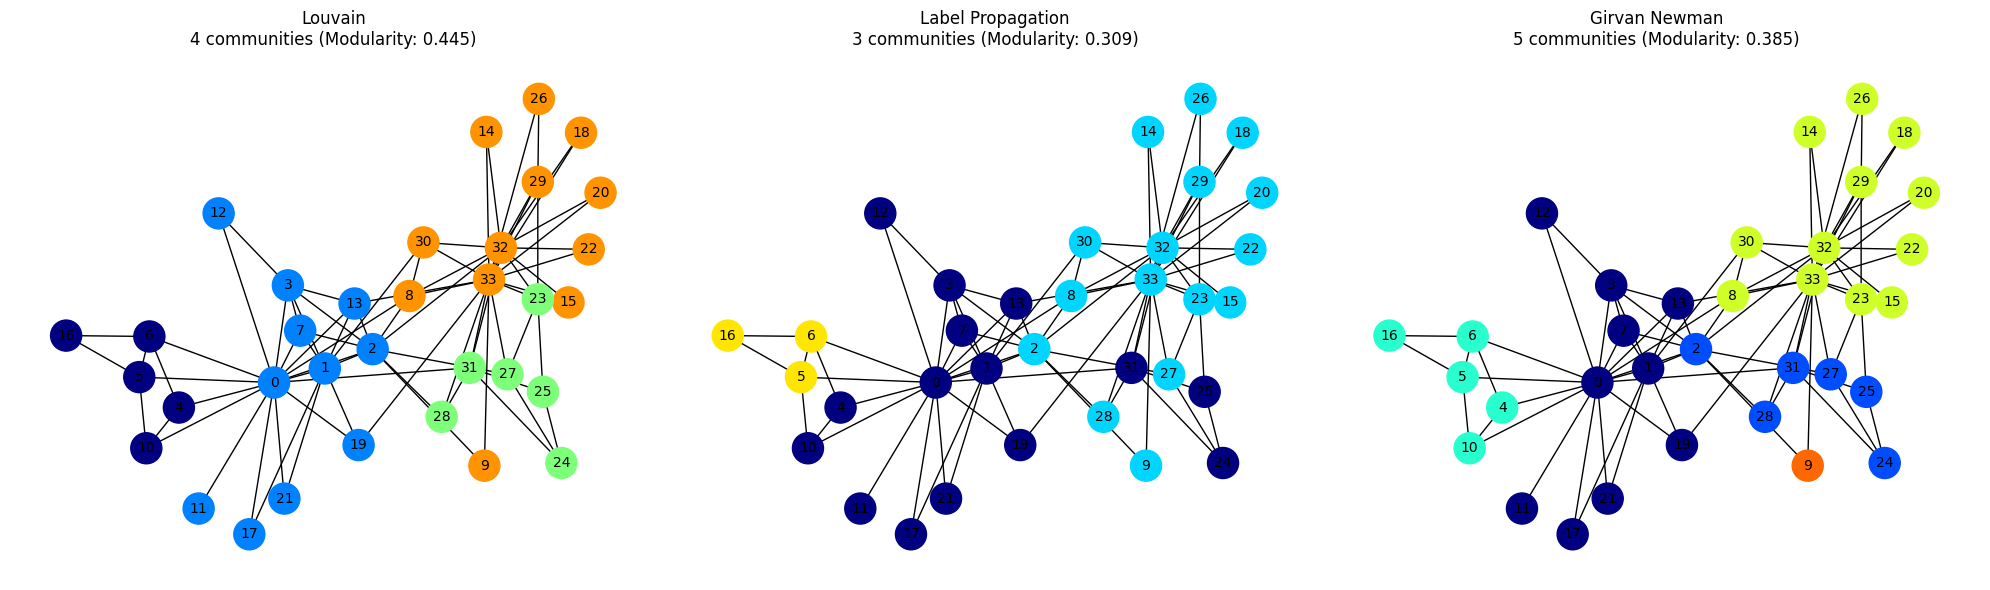

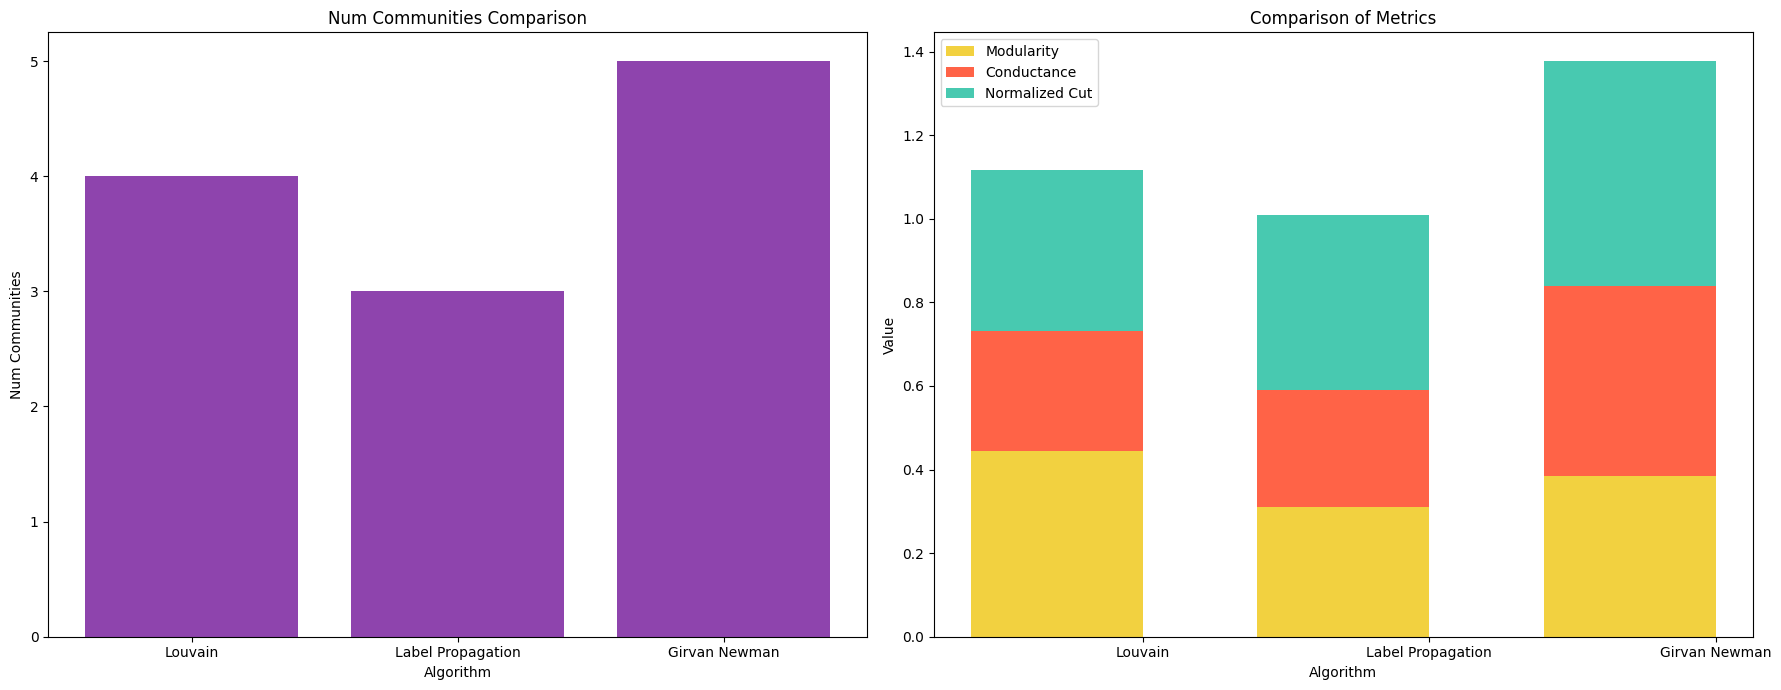


2. Analyzing Custom Generated Graph:

Custom Graph Metrics:
           Algorithm  Num Communities  Modularity  Conductance  Normalized Cut
0            Louvain                7     0.61075     0.242449        0.282753
1  Label Propagation                8     0.54835     0.333528        0.377254


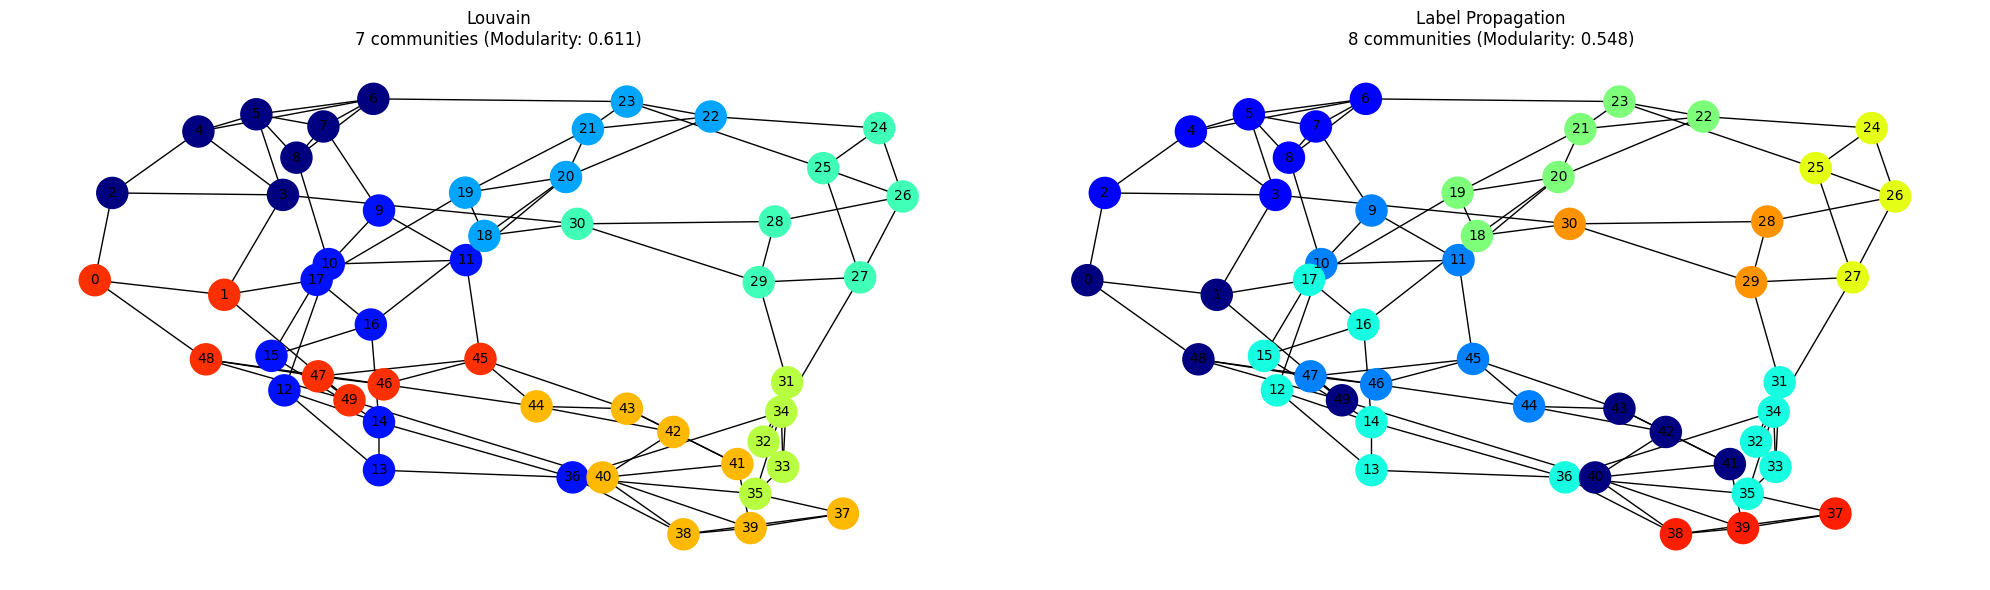

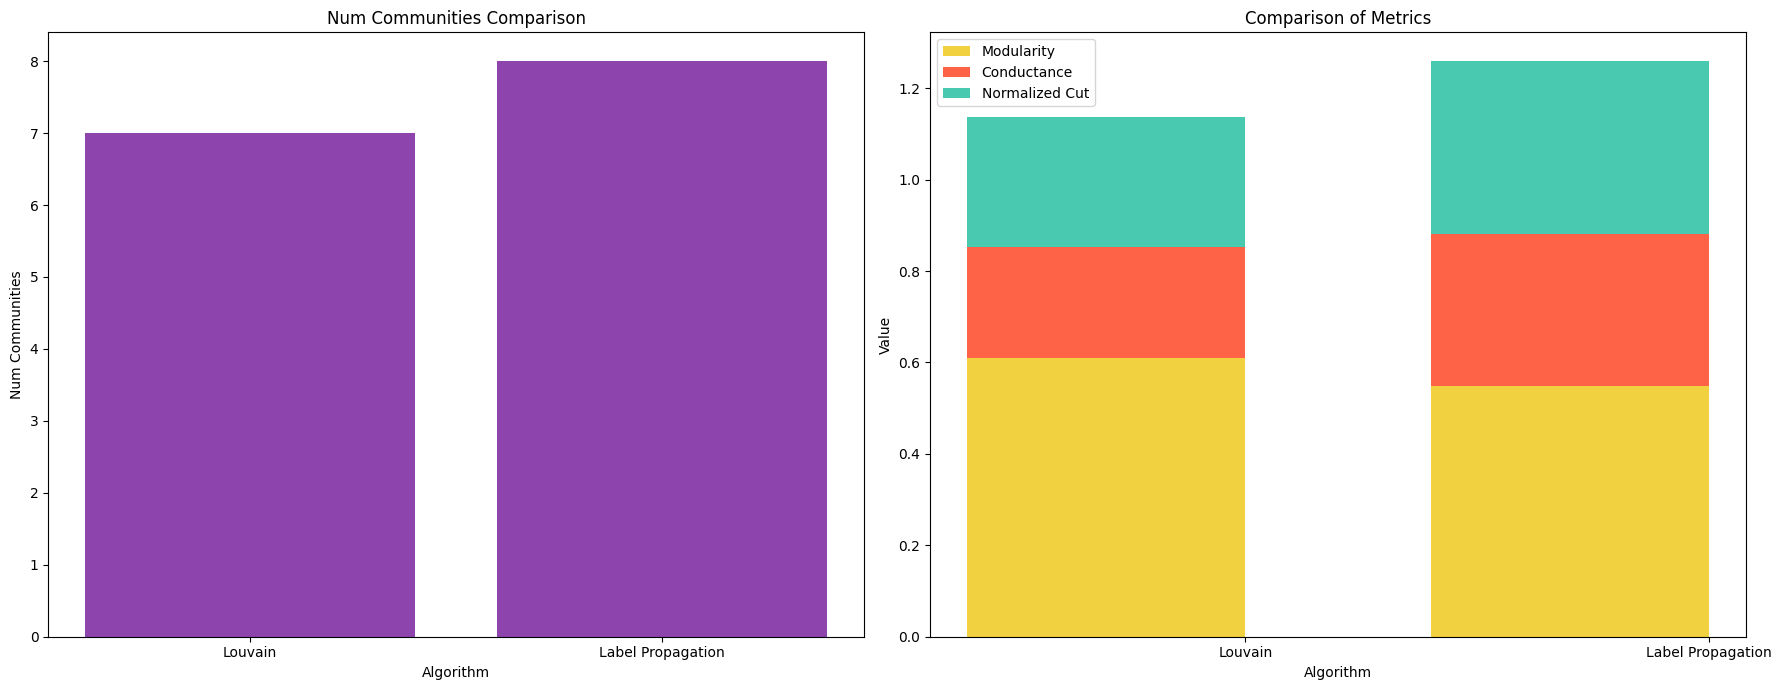


3. Analyzing Davis Southern Women Graph:

Davis Southern Women Graph Metrics:
  Algorithm  Num Communities  Modularity  Conductance  Normalized Cut
0   Louvain                3    0.334491     0.332996        0.486425


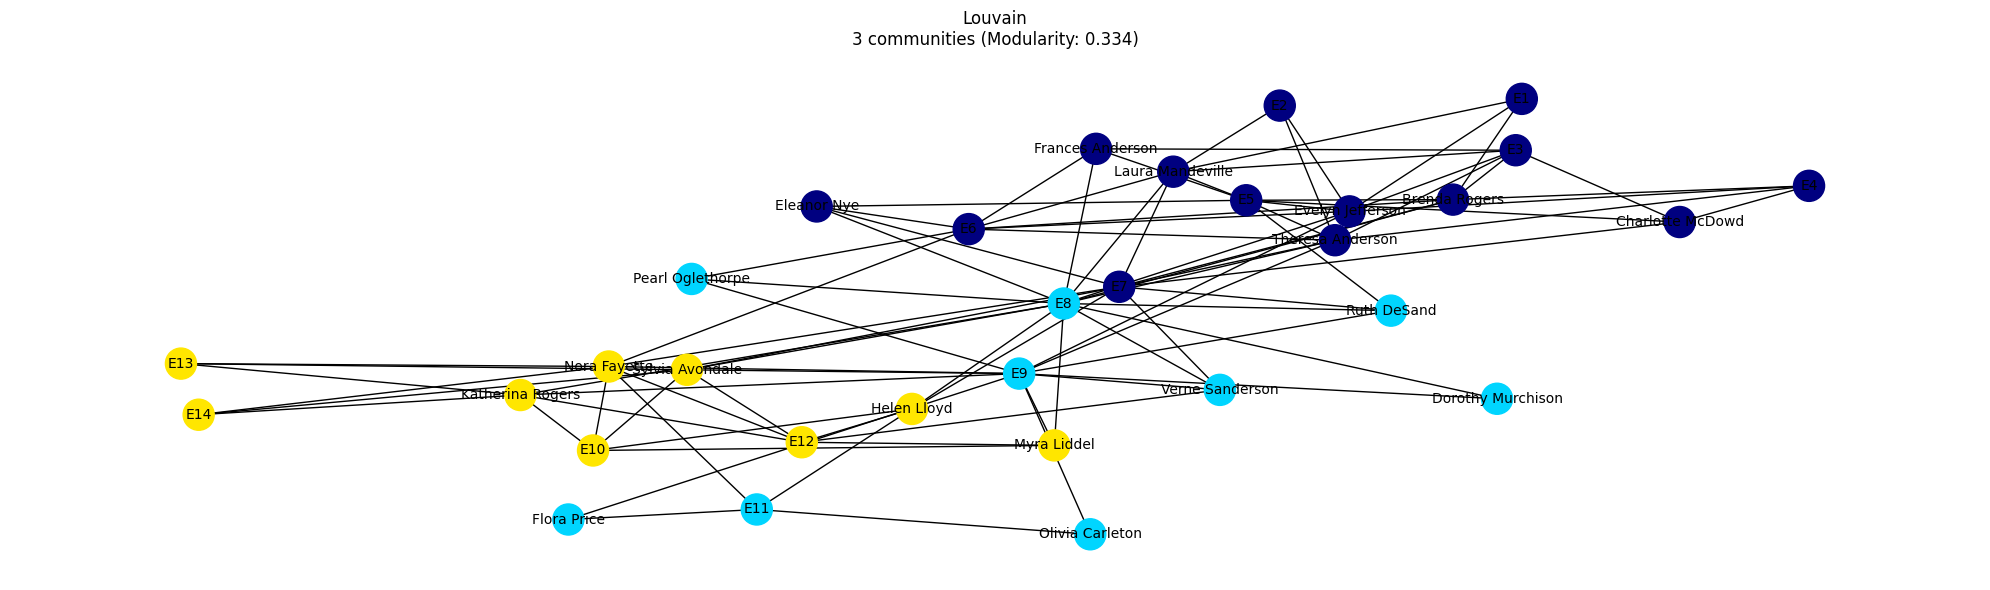

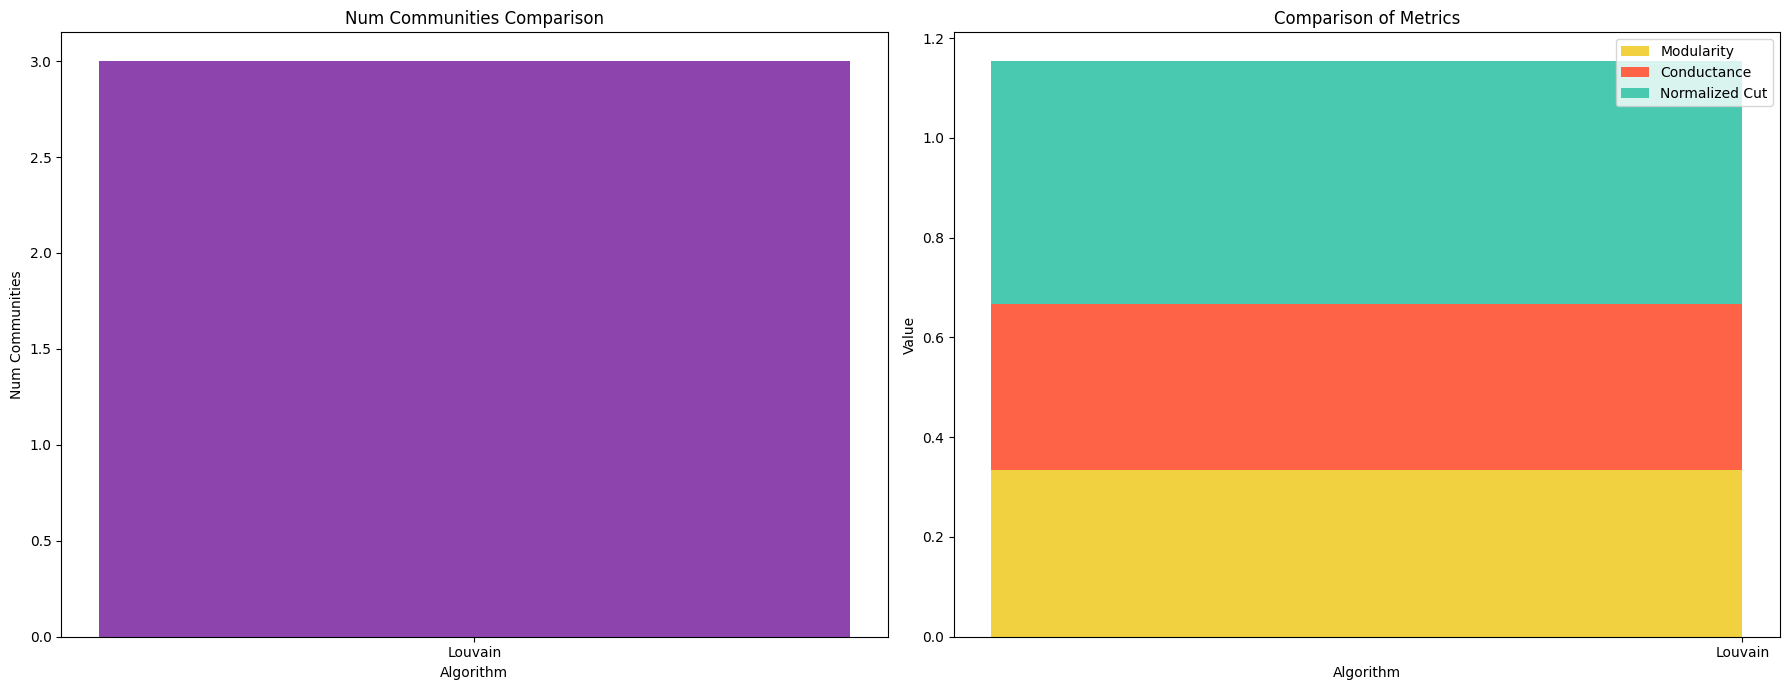

In [ ]:
def create_sample_graph() -> nx.Graph:
    """
    Create a sample social network graph for testing.

    Returns:
        A networkx Graph object
    """
    # Create a random graph using the Watts-Strogatz model
    n = 50  # number of nodes
    k = 4   # each node is connected to k nearest neighbors
    p = 0.1 # probability of rewiring each edge

    return nx.watts_strogatz_graph(n, k, p, seed=42)

def main():
    """
    Main function to demonstrate the usage of the CommunityDetectionPipeline.
    """
    print("Community Detection Pipeline Demo")
    print("-" * 30)

    # Example 1: Using Karate Club graph
    print("\n1. Analyzing Karate Club Graph:")
    G_karate = nx.karate_club_graph()
    pipeline_karate = CommunityDetectionPipeline(G_karate)
    pipeline_karate.detect_communities()
    pipeline_karate.calculate_metrics()
    print("\nKarate Club Graph Metrics:")
    print(pipeline_karate.create_metrics_dataframe().to_string())
    pipeline_karate.visualize_communities()
    pipeline_karate.plot_metrics_comparison()

    # Example 2: Using a custom generated graph
    print("\n2. Analyzing Custom Generated Graph:")
    G_custom = create_sample_graph()
    pipeline_custom = CommunityDetectionPipeline(G_custom)

    # Using only specific methods
    methods = ['louvain', 'label_propagation']  # excluding girvan_newman for faster execution
    pipeline_custom.detect_communities(methods=methods)
    pipeline_custom.calculate_metrics()
    print("\nCustom Graph Metrics:")
    print(pipeline_custom.create_metrics_dataframe().to_string())
    pipeline_custom.visualize_communities()
    pipeline_custom.plot_metrics_comparison()

    # Example 3: Using a real-world network (if available)
    try:
        # Try to load a real-world network from networkx dataset
        G_real = nx.davis_southern_women_graph()
        print("\n3. Analyzing Davis Southern Women Graph:")
        pipeline_real = CommunityDetectionPipeline(G_real)
        pipeline_real.detect_communities(methods=['louvain'])  # Using only Louvain for this example
        pipeline_real.calculate_metrics()
        print("\nDavis Southern Women Graph Metrics:")
        print(pipeline_real.create_metrics_dataframe().to_string())
        pipeline_real.visualize_communities()
        pipeline_real.plot_metrics_comparison()
    except Exception as e:
        print(f"\nSkipping real-world network analysis: {str(e)}")

if __name__ == "__main__":
    main()